# Doing Super-Resolution with TensorFlow
### In this project we implement single image super resolution using CNN, by reproducing a research paper [Learning a Deep Convolutional Network for Image Super-Resolution](https://link.springer.com/chapter/10.1007/978-3-319-10593-2_13) by Dong et al. (2014)

Ahsan Ahmed (22812)

Dua Qadeer (22820)

Arisha Rashid (23005)

Aman Razi Kidwai (22790)

Single image super-resolution (SR) is a classical computer vision problem that aims at recovering a high-resolution image from a lower resolution image. There are example based methods to solve it, such as mapping or using internal similarities but we looked into a method proposed by Dong et. al

In this project, we use a technique called Super Resolution Convolutional Neural Network. This technique work end to end by extacting patches from the low resolution image and passing them throw convolutional layers to final map them to higher resolution output pixels, as shown in the diagram below.

We implemented the SRCNN model in TensorFlow, trained it and then tested it on a low resolution image.

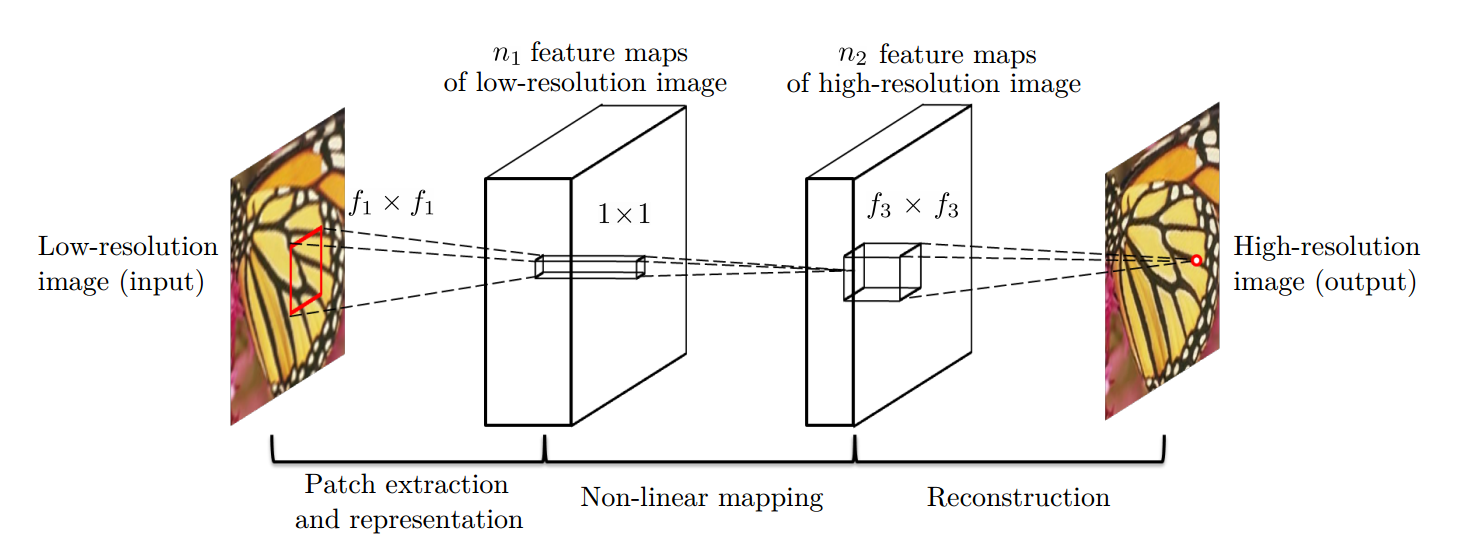

Given a low-resolution image Y, the first convolutional layer of the SRCNN extracts a set of feature maps. The second layer maps these feature maps nonlinearly to high-resolution patch representations. The last layer combines the predictions within a spatial neighbourhood to produce the final high-resolution image F(Y). (Dong et al.,2014)

As an image dataset for training the model, we will be using a Kaggle hosted dataset called [Dog and Cat Detection](https://www.kaggle.com/datasets/andrewmvd/dog-and-cat-detection).

In [ ]:
!pip install -q kaggle

In [ ]:
# upload kaggle.JSON file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"duaqadeer","key":"79bc240fb50b8a3e7277a06ff86f622d"}'}

In [ ]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%%capture
%%bash

pip install -q kaggle

mkdir -p ~/.kaggle
echo '{"username":"KAGGLE_USERNAME","key":"KAGGLE_KEY"}' > ~/.kaggle/kaggle.json
chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%%capture
%%bash

kaggle datasets download andrewmvd/dog-and-cat-detection
unzip -q dog-and-cat-detection.zip

In [ ]:
# mount drive to save checkpoints and trained model at end
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import dependencies
import os
import pathlib
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import *

In [ ]:
#set random seed for reproducability
SEED = 31
np.random.seed(SEED)

## Pre-processing

In [ ]:
# function to resize images based on a scale factor
def resize_image(image_array, factor):
    original_image = Image.fromarray(image_array)
    new_size = np.array(original_image.size) * factor
    new_size = new_size.astype(np.int32)
    new_size = tuple(new_size)
    resized = original_image.resize(new_size)
    resized = img_to_array(resized)
    resized = resized.astype(np.uint8)
    return resized

In [ ]:
# function to downsize then upsize image to create low res images
def downsize_upsize_image(image, scale):
    scaled = resize_image(image, 1.0 / scale)
    scaled = resize_image(scaled, scale / 1.0)
    return scaled

In [ ]:
# function to crop image to fit in sliding window (when extracting patches)
def tight_crop_image(image, scale):
    height, width = image.shape[:2]
    width -= int(width % scale)
    height -= int(height % scale)
    return image[:height, :width]

The following function is used to extract patches with a sliding window from an input image. The `INPUT_DIM` parameter is the height and width of the images as expected by the network

In [ ]:
def crop_input(image, x, y):
    y_slice = slice(y, y + INPUT_DIM)
    x_slice = slice(x, x + INPUT_DIM)
    return image[y_slice, x_slice]

Similarly, we need to crop patches from the output images with `LABEL_SIZE` the height and width of the output of the network. We also need to pad the patches with `PAD` to make sure we are cropping the regions properly

In [ ]:
def crop_output(image, x, y):
    y_slice = slice(y + PAD, y + PAD + LABEL_SIZE)
    x_slice = slice(x + PAD, x + PAD + LABEL_SIZE)
    return image[y_slice, x_slice]

Now let's read all image paths

In [ ]:
file_patten = (pathlib.Path('/content') / 'images' / '*.png')
file_pattern = str(file_patten)
dataset_paths = [*glob(file_pattern)]

We don't need the entire dataset as this will take longer training, but will sample around 1000 images from it

In [ ]:
SUBSET_SIZE = 1000
dataset_paths = np.random.choice(dataset_paths, SUBSET_SIZE)

Here is an example image from the dataset

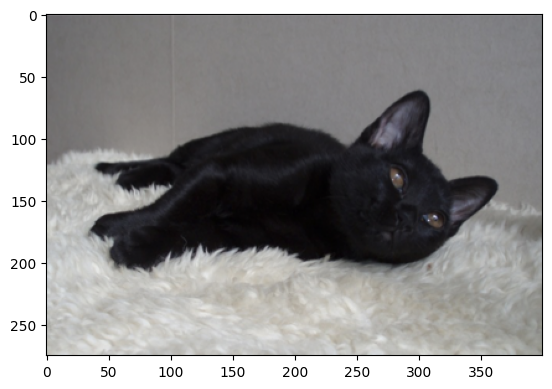

In [ ]:
path = np.random.choice(dataset_paths)
img = plt.imread(path)
plt.imshow(img)

Here we define some parameters, like the scale for resiping, input and output patch sizes, the amount of padding that need to be added to output patches, and the stride which is the number of pixels we'll slide both in the horizontal and vertical axes to extract patches.

In [ ]:
SCALE = 2.0
INPUT_DIM = 33
LABEL_SIZE = 21
PAD = int((INPUT_DIM - LABEL_SIZE) / 2.0)
STRIDE = 14

Now, lets build the dataset by reading the input images, generating a low resolution version, sliding a window on this low resolution image as well as the original image to generate patches for training.
We will save the patches to disk and later build a training data generator that will load them from disk in batches.

In [ ]:
%%bash

mkdir -p data
mkdir -p training

In [ ]:
for image_path in tqdm(dataset_paths):
    filename = pathlib.Path(image_path).stem
    image = load_img(image_path)
    image = img_to_array(image)
    image = image.astype(np.uint8)
    image = tight_crop_image(image, SCALE)
    scaled = downsize_upsize_image(image, SCALE)

    height, width = image.shape[:2]

    for y in range(0, height - INPUT_DIM + 1, STRIDE):
        for x in range(0, width - INPUT_DIM + 1, STRIDE):
            crop = crop_input(scaled, x, y)
            target = crop_output(image, x, y)
            np.save(f'data/{filename}_{x}_{y}_input.np', crop)
            np.save(f'data/{filename}_{x}_{y}_output.np', target)



100%|██████████| 1000/1000 [05:54<00:00,  2.82it/s]


We cannot hold all the patches in memory hence we saved to disk in the previous step. Now we need a dataset loader that will load a patch and its label and feed them to the network during traning in batches. This is achieved with the `PatchesDataset` class (check this example to learn more about generators - [link](https://dzlab.github.io/dltips/en/keras/data-generator/)).

In [ ]:
class PatchesDataset(tf.keras.utils.Sequence):
    def __init__(self, batch_size, *args, **kwargs):
        self.batch_size = batch_size
        self.input = [*glob('data/*_input.np.npy')]
        self.output = [*glob('data/*_output.np.npy')]
        self.input.sort()
        self.output.sort()
        self.total_data = len(self.input)

    def __len__(self):
        # returns the number of batches
        return int(self.total_data / self.batch_size)

    def __getitem__(self, index):
        # returns one batch
        indices = self.random_indices()
        input = np.array([np.load(self.input[idx]) for idx in indices])
        output = np.array([np.load(self.output[idx]) for idx in indices])
        return input, output

    def random_indices(self):
        return np.random.choice(list(range(self.total_data)), self.batch_size, p=np.ones(self.total_data)/self.total_data)


Define a batch size based on how much memory available on your GPU and create an instance of the dataset generator.

In [ ]:
BATCH_SIZE = 1024
train_ds = PatchesDataset(BATCH_SIZE)
len(train_ds)

621

You can see the shape of the training batches

In [ ]:
input, output = train_ds[0]
input.shape, output.shape

((1024, 33, 33, 3), (1024, 21, 21, 3))

## Training Model

The architecture of the SRCNN model is very simple, it has only convolutional layers, one to downsize the input and extract image features and a later one to upside to generate the output image. The following helper function is used to create an instance of the model.

In [ ]:
def create_model(height, width, depth):
    input = Input(shape=(height, width, depth))
    x = Conv2D(filters=64, kernel_size=(9, 9), kernel_initializer='he_normal')(input)
    x = ReLU()(x)
    x = Conv2D(filters=32, kernel_size=(1, 1), kernel_initializer='he_normal')(x)
    x = ReLU()(x)
    output = Conv2D(filters=depth, kernel_size=(5, 5), kernel_initializer='he_normal')(x)
    return Model(input, output)

To train the network we will use `Adam` as optimizer with learning rate decay. Also, as the problem we try to train the network for is a regression problem (we want predict the high resolution pixels) we pick `MSE` as a loss function, this will make the model learn the filters that correctly map patches from low to high resolution.

In [ ]:
EPOCHS = 12
optimizer = Adam(learning_rate=1e-3, decay=1e-3 / EPOCHS)
model = create_model(INPUT_DIM, INPUT_DIM, 3)
model.compile(loss='mse', optimizer=optimizer)

You can see how the model is small but astonishly it will be able to achieve great results once trained for enough time, we will train it for 12 epochs

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33, 33, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 25, 25, 64)        15616     
                                                                 
 re_lu (ReLU)                (None, 25, 25, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        2080      
                                                                 
 re_lu_1 (ReLU)              (None, 25, 25, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 3)         2403      
                                                                 
Total params: 20099 (78.51 KB)
Trainable params: 20099 (78.51

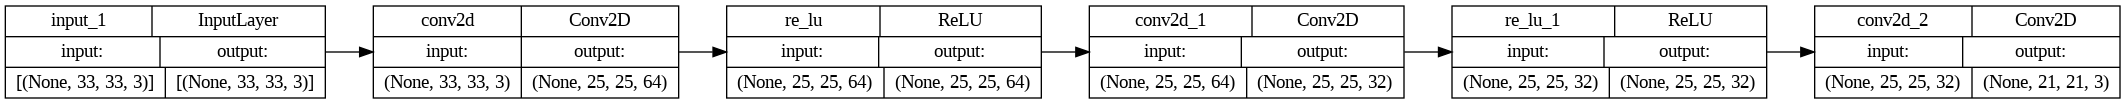

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True, rankdir='LR')

Create a callback that saves the model's weights

In [ ]:
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

Now finally, we can train the network

In [ ]:
model.fit(train_ds, epochs=EPOCHS, callbacks=[cp_callback])

Epoch 1/12
621/621 [==============================] - ETA: 0s - loss: 310.0132
Epoch 1: saving model to training/cp.ckpt
621/621 [==============================] - 738s 1s/step - loss: 310.0132
Epoch 2/12
621/621 [==============================] - ETA: 0s - loss: 118.3521
Epoch 2: saving model to training/cp.ckpt
621/621 [==============================] - 654s 1s/step - loss: 118.3521
Epoch 3/12
621/621 [==============================] - ETA: 0s - loss: 112.2785
Epoch 3: saving model to training/cp.ckpt
621/621 [==============================] - 631s 1s/step - loss: 112.2785
Epoch 4/12
621/621 [==============================] - ETA: 0s - loss: 109.0626
Epoch 4: saving model to training/cp.ckpt
621/621 [==============================] - 579s 932ms/step - loss: 109.0626
Epoch 5/12
621/621 [==============================] - ETA: 0s - loss: 107.7138
Epoch 5: saving model to training/cp.ckpt
621/621 [==============================] - 586s 943ms/step - loss: 107.7138
Epoch 6/12
621/621 [====

make sure `super_resolution` folder exists in Google Drive

In [ ]:
%%bash

mkdir -p /content/drive/MyDrive/super_resolution
cp -r training/* /content/drive/MyDrive/super_resolution

save and load the model

In [ ]:
path = '/content/drive/MyDrive/super_resolution/model.h5'
model.save(path)
new_model = tf.keras.models.load_model(path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Output

After train the model for enough time we can evaluate it. Let's pick a random image from the dataset (or you can use anyother image) and transform it into a low resolution image that we can pass to the SRCNN model.

In [ ]:
path = np.random.choice(dataset_paths)
image = load_img(path)
image = img_to_array(image)
image = image.astype(np.uint8)
image = tight_crop_image(image, SCALE)
scaled = downsize_upsize_image(image, SCALE)

We need a placeholder where we will put the output patches to create the final image

In [ ]:
output = np.zeros(scaled.shape)
height, width = output.shape[:2]

Now we extract patches from the input image, pass them through the trained model to generate high resolution patch and then put this patch in the right position on the previous placeholder. After processing every patch from the input image we will have a final output image

In [ ]:
for y in range(0, height - INPUT_DIM + 1, LABEL_SIZE):
    for x in range(0, width - INPUT_DIM + 1, LABEL_SIZE):
        crop = crop_input(scaled, x, y)
        image_batch = np.expand_dims(crop, axis=0)
        prediction = model.predict(image_batch)
        new_shape = (LABEL_SIZE, LABEL_SIZE, 3)
        prediction = prediction.reshape(new_shape)
        output_y_slice = slice(y + PAD, y + PAD + LABEL_SIZE)
        output_x_slice = slice(x + PAD, x + PAD + LABEL_SIZE)
        output[output_y_slice, output_x_slice] = prediction

1/1 [==============================] - 0s 18ms/step


Now we can display side by side the low resolution image as well as the resulting output image which is of higher resolution.

(-0.5, 299.5, 155.5, -0.5)

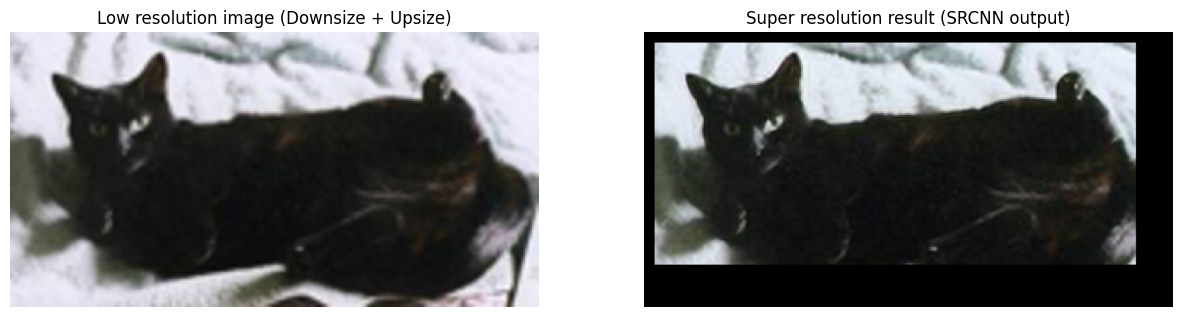

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(15, 8))
axis[0].imshow(np.array(scaled,np.int32))
axis[0].set_title('Low resolution image (Downsize + Upsize)')
axis[0].axis('off')

axis[1].imshow(np.array(output,np.int32))
axis[1].set_title('Super resolution result (SRCNN output)')
axis[1].axis('off')

Very impressive result considering the small model that we trained, as you can see it was able to considerably improve the resolution of the input image.